## Data preparation


### Reading Data


- read_data from dataset

- convert images to gray scale

- convert each image to a vector of 10304 value

- stack 400 vector into a single data matrix



In [2]:
import cv2
import numpy as np
import os


data_images = []

def process_image(path):
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data_images.append(gray_image)
    flattened_image = gray_image.flatten()
    flattened_image = np.array(flattened_image)
    return flattened_image

def read_data (no_of_folders, no_of_images): 

    path = "dataset\\s%d\\%d.pgm"

    data_matrix = np.empty((0, 10304))  
    label_vector = np.array([])

    for folder_counter in range (1, no_of_folders + 1):
        for image_counter in range (1, no_of_images + 1):
            processed_image = process_image(path%(folder_counter,image_counter))
            data_matrix = np.append(data_matrix, [processed_image], axis=0)
            label_vector = np.append(label_vector, folder_counter)
    
    print(data_matrix.shape)

    return data_matrix, label_vector

def read_nonfaces(no_of_images):

    folder_path= "processed_nonfaces_dataset"
    data_matrix = np.empty((0, 10304))  

    files = os.listdir(folder_path)
    
    files.sort()

    for file_name in files[:no_of_images]:
        
        file_path = os.path.join(folder_path, file_name)
        processed_image = process_image(file_path)
        data_matrix = np.append(data_matrix, [processed_image], axis=0)

  
    return data_matrix


# dm, lv = read_data( 40, 10)

# dm2 = read_nonfaces(400)

# cv2.imshow('image', data_images[500])
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(data_images[0].shape)

# print(dm2.shape)


### Splitting data to training and testing data

In [3]:


def split_data(data_matrix, label_vector ):
    
    test_data = data_matrix[::2] #even  
    training_data = data_matrix[1::2] #odd

    test_labels = label_vector[::2]
    training_labels = label_vector[1::2] 

    return test_data, training_data, training_labels, test_labels



In [32]:
import math
import numpy as np



def split_data2(data_matrix, label_vector, chunk_size, ratio):
    num_samples = len(data_matrix)
    num_chunks = math.ceil(num_samples / chunk_size)
    test_data_chunks = np.empty((0, 10304)) 
    training_data_chunks = np.empty((0, 10304)) 
    training_labels_chunks = np.array([])
    test_labels_chunks = np.array([])

    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = min((i + 1) * chunk_size, num_samples)

        chunk_data = data_matrix[start_index:end_index]
        chunk_labels = label_vector[start_index:end_index]

        split_index = int(chunk_size * ratio)

        test_data_chunk = chunk_data[:split_index]
        training_data_chunk = chunk_data[split_index:]

        test_labels_chunk = chunk_labels[:split_index]
        training_labels_chunk = chunk_labels[split_index:]

        test_data_chunks = np.concatenate((test_data_chunks, test_data_chunk))
        training_data_chunks = np.concatenate((training_data_chunks, training_data_chunk))
        training_labels_chunks = np.concatenate((training_labels_chunks, training_labels_chunk))
        test_labels_chunks = np.concatenate((test_labels_chunks, test_labels_chunk))

    return test_data_chunks, training_data_chunks, training_labels_chunks, test_labels_chunks


In [25]:
arr= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])
arr2 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])

test_Data, training_data, trainig_labels, test_labels = split_data2(arr, arr2, 10, 0.7)
print(test_Data)
print(training_data)


[ 1.  2.  3.  4.  5.  6.  7. 11. 12. 13. 14. 15. 16. 17. 21. 22. 23. 24.
 25. 26. 27. 31. 32. 33. 34. 35. 36. 37.]
[ 8.  9. 10. 18. 19. 20. 28. 29. 30. 38. 39. 40.]


## PCA Algorithm

In [33]:

def PCA(training_data, alpha):

    mean_vector = np.mean(training_data, axis=0)
   
    centered_training_data = training_data - mean_vector

    covariance_matrix = np.cov(np.transpose(centered_training_data), bias= True)
   
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
   

    sorted_indices = np.argsort(eigenvalues)[::-1]
   
    sorted_eigenvalues = eigenvalues[sorted_indices]

    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    accum = sorted_eigenvalues[0]
  
    sum = np.sum(sorted_eigenvalues)
  
    i = 1
   
    while( accum / sum < alpha):
        accum+=sorted_eigenvalues[i]
        i+=1

    projection_matrix = sorted_eigenvectors[:, :i]
  
    print("multiplying the two matrices")
    reduced_dimensionality_data = np.transpose(projection_matrix).dot(np.transpose(training_data))

    return np.transpose(reduced_dimensionality_data), projection_matrix



## PCA Classification analysis

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

data_matrix, label_vector = read_data(40, 10)

test_data, training_data, training_labels, test_labels = split_data2(data_matrix, label_vector, 2, 0.5)

reduced_dimensionality_data, projection_matrix = PCA(training_data, 0.95)

print("after PCA")

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)


print("after reducing test data")

knn_classifier = KNeighborsClassifier(n_neighbors=1)

knn_classifier.fit(reduced_dimensionality_data, training_labels)

print("after fit")

test_pred = knn_classifier.predict(reduced_dimensionality_test_data)

print("after prediction")

accuracy = accuracy_score(test_labels, test_pred)

print("Accuracy:", accuracy)


(400, 10304)
multiplying the two matrices
after PCA
after reducing test data
after fit
after prediction
Accuracy: 0.935


## Accuracy for every value of alpha using PCA.

as we see when alpha increase the accuracy increases.

but for alpha = 0.95 the accuracy decreases due to some reasons:
- Overfitting: many components might be including noise or irrelevant details from the data that can lead to overfitting
- Curse of dimensionality: when you have many features data becomes sparse and distances between points become less meaningful
- Not all variance is useful: PCA tries to keep the components that explain the most variance, but not all variance is useful for classification.

|  Alpha   | Accuracy |
| -------- | -------- |
| 0.8      | 0.93     |
| 0.85     | 0.94     |
| 0.9      | 0.945    |
| 0.95     | 0.935    |


## LDA 

In [21]:
import scipy as sc
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def LDA(training_data, training_labels):

    unique_values, counts = np.unique(training_labels, return_counts=True)
    

    mean_vector = np.mean(training_data, axis=0)
    sb=0
    s=0
    for i in range(unique_values.shape[0]):
        # print(unique_values[i], counts[i])
        class_i=training_data[np.where(training_labels==unique_values[i])]
        # print("class_i ")
        # print(class_i)
        class_mean_i = np.mean(class_i,axis=0)

        sb+=counts[i]*np.outer(class_mean_i-mean_vector,class_mean_i-mean_vector)
        z =class_i - class_mean_i
        s+= np.transpose(z).dot(z)

    # print(s)
    # print('-------------sb--------------')
    # print(sb)
    # print('-----------s-1 sb----------------')
    # print(np.linalg.inv(s).dot(sb))
    # print('-----------eigen values----------------')
    

    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(s).dot(sb))

    # eigenvalues = np.real(eigenvalues)
    # eigenvectors = np.real(eigenvectors)
    # print(eigenvalues)
    # print('------------eigen vectors---------------')
    # print(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    projection_matrix = sorted_eigenvectors[:, :unique_values.shape[0]-1]
    # projection_matrix = np.real(projection_matrix)
    # print('-----------projection matrix----------------')
    # print (projection_matrix)

    reduced_dimensionality_data = np.transpose(projection_matrix).dot(np.transpose(training_data))

    # print('------------result---------------')
    # print (np.transpose(reduced_dimensionality_data))

    return np.transpose(reduced_dimensionality_data), projection_matrix



# training_data = np.array([[4,2], [2,4], [2,3], [3,6], [4,4], [9,10], [6,8], [9,5], [8,7], [10,8]])
# training_labels = np.array([1,1,1,1,1,2,2,2,2,2])
# LDA(training_data, training_labels)





## LDA Classification Analysis

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



data_matrix, label_vector = read_data(40, 10)

test_data, training_data, training_labels, test_labels = split_data(data_matrix, label_vector)

reduced_dimensionality_data, projection_matrix = LDA(training_data, training_labels)

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)

knn_classifier = KNeighborsClassifier(n_neighbors=1)

knn_classifier.fit(reduced_dimensionality_data, training_labels)

test_pred = knn_classifier.predict(reduced_dimensionality_test_data)

accuracy = accuracy_score(test_labels, test_pred)

print("Accuracy:", accuracy)



(400, 10304)
1.0 5
class_i 
[[ 60.  60.  62. ...  32.  34.  34.]
 [ 63.  53.  35. ...  41.  10.  24.]
 [ 43.  50.  41. ... 158. 153. 169.]
 [ 44.  43.  32. ...  43.  43.  37.]
 [ 34.  34.  33. ...  37.  40.  33.]]
2.0 5
class_i 
[[ 37.  35.  35. ...  26.  28.  28.]
 [ 34.  36.  35. ...  32.  25.  25.]
 [ 34.  35.  35. ...  31.  24.  24.]
 [ 34.  39.  35. ... 135. 138. 148.]
 [ 37.  34.  38. ... 135. 143. 133.]]
3.0 5
class_i 
[[100.  99. 108. ...  44.  42.  44.]
 [105. 102. 108. ...  42.  35.  37.]
 [110. 106. 109. ...  49.  53.  53.]
 [107. 104. 109. ...  58.  56.  57.]
 [104. 109. 103. ...  57.  56.  59.]]
4.0 5
class_i 
[[116. 112. 115. ...  51.  55.  54.]
 [119. 121. 119. ...  82.  78.  80.]
 [121. 123. 121. ...  88.  83.  78.]
 [118. 114. 117. ...  58.  54.  52.]
 [119. 124. 118. ...  75.  77.  82.]]
5.0 5
class_i 
[[130. 132. 129. ...  53.  50.  52.]
 [130. 133. 129. ...  54.  54.  56.]
 [128. 128. 128. ...  87.  83.  86.]
 [132. 127. 128. ...  85.  83.  85.]
 [124. 125. 125. ...

### Classifier Tuning

In [ ]:
def test_with_k(reduced_dimensionality_data,training_labels,reduced_dimensionality_test_data,test_labels,k):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(reduced_dimensionality_data, training_labels)

    test_pred = knn_classifier.predict(reduced_dimensionality_test_data)

    accuracy = accuracy_score(test_labels, test_pred)

    print("Accuracy:", accuracy)
    return accuracy

#### LDA with k=1,3,5,7

In [ ]:
import matplotlib.pyplot as plt

data_matrix, label_vector = read_data()

test_data, training_data, training_labels, test_labels = split_data(data_matrix, label_vector)

reduced_dimensionality_data, projection_matrix = LDA(training_data)

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)

LDA_performance_with_recpect_to_k = []
for i in range (1,8,2):
    LDA_performance_with_recpect_to_k.append(test_with_k(reduced_dimensionality_data,training_labels,reduced_dimensionality_test_data,test_labels,i))
    
plt.plot(list(range(1,8,2)), LDA_performance_with_recpect_to_k , marker='o', linestyle='-')

# Add labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Data Plot')

# Show the plot
plt.grid(True)
plt.show()

#### PCA with k=1,3,5,7

In [31]:
import matplotlib.pyplot as plt

data_matrix, label_vector = read_data()

test_data, training_data, training_labels, test_labels = split_data(data_matrix, label_vector)

reduced_dimensionality_data, projection_matrix = PCA(training_data)

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)

PCA_performance_with_recpect_to_k = []
for i in range (1,8,2):
    PCA_performance_with_recpect_to_k.append(test_with_k(reduced_dimensionality_data,training_labels,reduced_dimensionality_test_data,test_labels,i))
    
plt.plot(list(range(1,8,2)), PCA_performance_with_recpect_to_k , marker='o', linestyle='-')

# Add labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Data Plot')

# Show the plot
plt.grid(True)
plt.show()

[[1, 2], [3, 4]]


## PCA with k=1,3,5,7 => 70%, 30%


In [ ]:
import matplotlib.pyplot as plt

data_matrix, label_vector = read_data()

test_data, training_data, training_labels, test_labels = split_data2(data_matrix, label_vector, 10, 0.3)

reduced_dimensionality_data, projection_matrix = PCA(training_data)

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)

PCA_performance_with_recpect_to_k = []
for i in range (1,8,2):
    PCA_performance_with_recpect_to_k.append(test_with_k(reduced_dimensionality_data,training_labels,reduced_dimensionality_test_data,test_labels,i))
    
plt.plot(list(range(1,8,2)), PCA_performance_with_recpect_to_k , marker='o', linestyle='-')

# Add labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Data Plot')

# Show the plot
plt.grid(True)
plt.show()

## LDA with k=1,3,5,7 => 70%, 30%

In [ ]:
import matplotlib.pyplot as plt

data_matrix, label_vector = read_data()

test_data, training_data, training_labels, test_labels = split_data(data_matrix, label_vector, 10, 0.3)

reduced_dimensionality_data, projection_matrix = LDA(training_data)

reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)

LDA_performance_with_recpect_to_k = []
for i in range (1,8,2):
    LDA_performance_with_recpect_to_k.append(test_with_k(reduced_dimensionality_data,training_labels,reduced_dimensionality_test_data,test_labels,i))
    
plt.plot(list(range(1,8,2)), LDA_performance_with_recpect_to_k , marker='o', linestyle='-')

# Add labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Data Plot')

# Show the plot
plt.grid(True)
plt.show()

# Faces VS Non-Faces PCA

In [6]:
#none face is 1 ... face is 2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

data_labels =np.array( [1]*400 + [2]*400)
data_images = []
non_faces_data_matrix = read_nonfaces(400)
faces_data_matrix, label_data = read_data(40, 10)

data_matrix = np.concatenate((non_faces_data_matrix, faces_data_matrix), axis=0)
print(data_labels.shape)
print("---- after concatenation ----")
print(data_matrix.shape)
test_data, training_data, training_labels, test_labels = split_data(data_matrix, data_labels)

test_images, training_images, training_labels, test_labels = split_data(np.array(data_images), data_labels)

print(test_images.shape)

print("---- after split ----")
print(training_data.shape)
print(training_labels.shape)
reduced_dimensionality_data, projection_matrix = PCA(training_data, 0.9)

print("after PCA")
print(reduced_dimensionality_data.shape)
reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)


print("after reducing test data")

knn_classifier = KNeighborsClassifier(n_neighbors=1)

knn_classifier.fit(reduced_dimensionality_data, training_labels)

print("after fit")

test_pred = knn_classifier.predict(reduced_dimensionality_test_data)

print("after prediction")

accuracy = accuracy_score(test_labels, test_pred)

# _, ax = plt.subplots(test_labels.shape[0], 1, figsize=(12, 60))
# for i in range(test_labels.shape[0]):
#     if test_labels[i] != test_pred[i]:
#         print("predicted: ", test_pred[i], "actual: ", test_labels[i])
#         ax[i].imshow(test_images[i], cmap='gray')
#     else:
#         ax[i].imshow(test_images[i], cmap='gray')

# _, ax = plt.subplots(test_labels.shape[0], 1, figsize=(24, 80))
# for i in range(test_labels.shape[0]):
#     # if test_labels[i] != test_pred[i]:
#     #     text = f"Predicted: {test_pred[i]}, Actual: {test_labels[i]} (Incorrect)"
#     #     ax[i].text(0.5, 0.5, text, horizontalalignment='center', verticalalignment='center')
#     # else:
#     #     text = f"Predicted: {test_pred[i]}, Actual: {test_labels[i]} (Correct)"
#     #     ax[i].text(0.5, 0.5, text, horizontalalignment='center', verticalalignment='center')
#     ax[i].imshow(test_images[i], cmap='gray')
#     ax[i].axis('off')  # Turn off axis for cleaner visualization
# # plt.tight_layout()  # Adjust layout to prevent overlap
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.5)

# plt.show()



print("Accuracy:", accuracy)

(400, 10304)
(800,)
---- after concatenation ----
(800, 10304)
(400, 112, 92)
---- after split ----
(400, 10304)
(400,)
multiplying the two matrices
after PCA
(400, 83)
after reducing test data
after fit
after prediction
Accuracy: 0.955


In [ ]:


success_images = []
failure_images = []
failure_predictions = []
failure_labels = []
success_predictions = []
success_labels = []
for i in range(test_labels.shape[0]):
    if test_labels[i] != test_pred[i]:
        failure_images.append(test_images[i])
        failure_predictions.append(test_pred[i])
        failure_labels.append(test_labels[i])
    else:
        success_images.append(test_images[i])
        success_predictions.append(test_pred[i])
        success_labels.append(test_labels[i])   


In [18]:
def plot(images, predictions, labels):
    _, ax = plt.subplots(len(images), 1, figsize=(60, 100))
    for i in range(len(images)):
        text = f"Predicted: {predictions[i]}, Actual: {labels[i]}\n (Correct)"
        ax[i].text(0.5, 0.1, text, horizontalalignment='center', verticalalignment='center')
        ax[i].imshow(images[i], cmap='gray', interpolation='nearest')
        ax[i].axis('off')  
    plt.tight_layout()  
    plt.show()

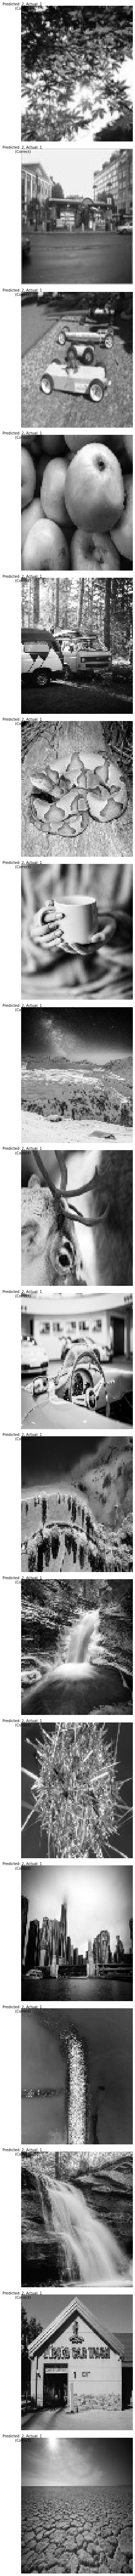

In [19]:
plot(failure_images, failure_predictions, failure_labels)

In [ ]:
plot(success_images, success_predictions, success_labels)

# To Do
- compare with different sizes of non face training data
- Use different training and test splits



### Compare with different sizes of training data PCA



In [36]:
# This has to be reoeated with LDA
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

data_labels =np.array( [1]*400 + [2]*400)
data_images = []
non_faces_data_matrix = read_nonfaces(400)
faces_data_matrix, label_data = read_data(40, 10)

data_matrix = np.concatenate((non_faces_data_matrix, faces_data_matrix), axis=0)
print(data_labels.shape)
print("---- after concatenation ----")
print(data_matrix.shape)
test_data, training_data, training_labels, test_labels = split_data2(data_matrix, data_labels, 10, 0.7)

accuracies = []
for i in range (0, 400, 100):

    reduced_dimensionality_data, projection_matrix = PCA(training_data[i:], 0.9)
    print("loop ",i)
    print(reduced_dimensionality_data.shape)
    print(training_labels[i:].shape)
    reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
    reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)
    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(reduced_dimensionality_data, training_labels[i:])
    test_pred = knn_classifier.predict(reduced_dimensionality_test_data)
    accuracy = accuracy_score(test_labels, test_pred)
    accuracies.append(accuracy)

plt.plot(list(range(400,0,-100)), accuracies , marker='o', linestyle='-')


print("Accuracy:", accuracy)

(400, 10304)
(800,)
---- after concatenation ----
(800, 10304)
multiplying the two matrices
multiplying the two matrices
multiplying the two matrices


C:\Users\Samni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Samni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Samni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Samni\AppData\Local\Temp\ipykernel_8116\3424300096.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_matrix = np.cov(np.transpose(centered_training_data), bias= True)
C:\Users\Samni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_q

multiplying the two matrices


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNeighborsClassifier.

## Compare with different sizes of training data LDA

In [ ]:
# This has to be reoeated with LDA
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

data_labels =np.array( [1]*400 + [2]*400)
data_images = []
non_faces_data_matrix = read_nonfaces(400)
faces_data_matrix, label_data = read_data(40, 10)

data_matrix = np.concatenate((non_faces_data_matrix, faces_data_matrix), axis=0)
print(data_labels.shape)
print("---- after concatenation ----")
print(data_matrix.shape)
test_data, training_data, training_labels, test_labels = split_data2(data_matrix, data_labels, 10, 0.7)

accuracies = []
for i in range (0, 351, 50):

    reduced_dimensionality_data, projection_matrix = LDA(training_data[i:], training_labels[i:])
    reduced_dimensionality_test_data = np.transpose(projection_matrix).dot(np.transpose(test_data))
    reduced_dimensionality_test_data = np.transpose(reduced_dimensionality_test_data)
    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(reduced_dimensionality_data, training_labels)
    test_pred = knn_classifier.predict(reduced_dimensionality_test_data)
    accuracy = accuracy_score(test_labels, test_pred)
    accuracies.append(accuracy)

plt.plot(list(range(400,0,-50)), accuracies , marker='o', linestyle='-')


print("Accuracy:", accuracy)